In [31]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import toml
import tqdm

In [32]:
def logdir2df(logdir):
    """convert tf.events files in a logs directory into a pandas DataFrame

    tf.events files are created by SummaryWriter from PyTorch or Tensorflow

    Parameters
    ----------
    logdir : str, Path
        path to directory containing tfevents file(s) saved by a SummaryWriter

    Returns
    -------
    df : pandas.Dataframe
        with columns 'step', 'wall_time', and all Scalars from the tfevents file
    """
    if issubclass(type(logdir), Path):
        logdir = str(logdir)

    ea = EventAccumulator(path=logdir)
    ea.Reload()  # load all data written so far

    scalar_tags = ea.Tags()['scalars']  # list of tags for values written to scalar

    dfs = {}

    for scalar_tag in scalar_tags:
        dfs[scalar_tag] = pd.DataFrame(ea.Scalars(scalar_tag),
                                       columns=["wall_time",
                                                "step",
                                                scalar_tag.replace('val/', '')])
        dfs[scalar_tag] = dfs[scalar_tag].set_index("step")
        dfs[scalar_tag].drop("wall_time", axis=1, inplace=True)
    return pd.concat([v for k, v in dfs.items()], axis=1)


def logdir2csv(logdir):
    """convert tf.events files in a logs directory into a pandas DataFrame

    Parameters
    ----------
    logdir

    Returns
    -------

    """
    df = logdir2df(logdir)
    name = list(logdir.glob('*tfevents*'))[0].name
    csv_fname = name + '.csv'
    df.to_csv(logdir.joinpath(csv_fname))

In [33]:
re_int = re.compile(r'[0-9]+')

def int_from_dir_path(dir_path):
    name = dir_path.name
    return int(re_int.search(name)[0])

In [34]:
BR_RESULTS_ROOT = Path('~/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition').expanduser().resolve()

In [35]:
BIRD_RESULTS_ROOT = BR_RESULTS_ROOT.joinpath('Bird0')

In [36]:
sorted(BIRD_RESULTS_ROOT.iterdir())

[PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200428_220025'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200428_221552'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200428_222824'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200501_171235')]

In [37]:
RESULTS_ROOT = BIRD_RESULTS_ROOT.joinpath('results_200501_171235')

In [38]:
train_dur_dirs = sorted(RESULTS_ROOT.glob('train_dur_*'), key=int_from_dir_path)

In [39]:
train_dur_dirs

[PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200501_171235/train_dur_30s'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200501_171235/train_dur_45s'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200501_171235/train_dur_75s'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200501_171235/train_dur_120s'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200501_171235/train_dur_180s'),
 PosixPath('/home/bart/Documents/repos/birdsong/tweetynet/results/BirdsongRecognition/Bird0/results_200501_171235/train_dur_480s')]

In [40]:
train_history_dfs = {}

for train_dur_dir in train_dur_dirs:
    train_dur = int_from_dir_path(train_dur_dir)
    print(f'getting tf.events files for training duration: {train_dur}')
    train_history_dfs[train_dur] = {}
    replicate_dirs = sorted(train_dur_dir.glob('replicate_*'), key=int_from_dir_path)
    for replicate_dir in replicate_dirs:
        replicate_num = int_from_dir_path(replicate_dir)
        print(f'\treplicate: {replicate_num}')
        events_file = sorted(replicate_dir.glob('**/events*'))
        assert len(events_file) == 1
        events_file = events_file[0]
        logdir = events_file.parent
        log_df = logdir2df(logdir)
        train_history_dfs[train_dur][replicate_num] = log_df

getting tf.events files for training duration: 30
	replicate: 1
	replicate: 2
	replicate: 3
	replicate: 4
getting tf.events files for training duration: 45
	replicate: 1
	replicate: 2
	replicate: 3
	replicate: 4
getting tf.events files for training duration: 75
	replicate: 1
	replicate: 2
	replicate: 3
	replicate: 4
getting tf.events files for training duration: 120
	replicate: 1
	replicate: 2
	replicate: 3
	replicate: 4
getting tf.events files for training duration: 180
	replicate: 1
	replicate: 2
	replicate: 3
	replicate: 4
getting tf.events files for training duration: 480
	replicate: 1
	replicate: 2
	replicate: 3
	replicate: 4


In [41]:
for train_dur, replicate_df_dict in train_history_dfs.items():
    for replicate, df in replicate_df_dict.items():
        df['avg_error/val'] = 1 - df['avg_acc/val']

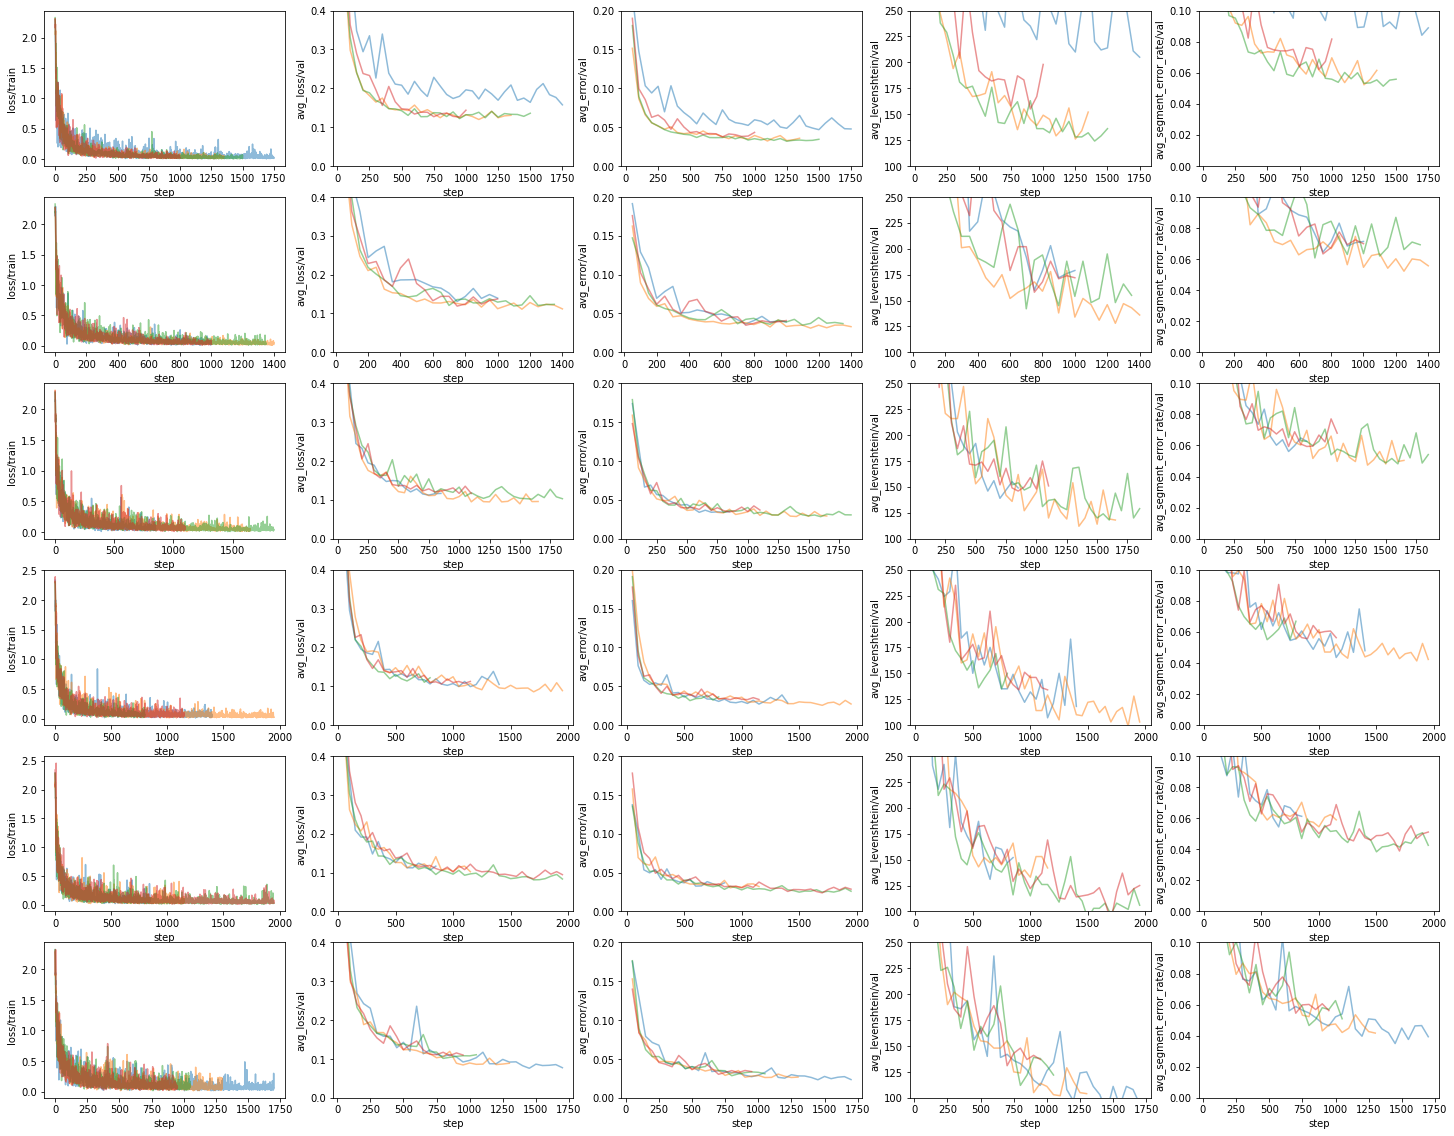

In [42]:
n_train_durs = len(train_history_dfs)
a_train_dur = list(train_history_dfs)[0]
n_replicates = len(train_history_dfs[a_train_dur])


fig, ax = plt.subplots(n_train_durs, 5, figsize=(25, 20))

train_durs = sorted(train_history_dfs.keys())
for row_ind, train_dur in enumerate(train_durs):
    replicate_df_dict = train_history_dfs[train_dur]
    replicate_nums = sorted(replicate_df_dict.keys())
    for replicate_num, df in replicate_df_dict.items():
        sns.lineplot(x=df.index, y='loss/train', data=df, ax=ax[row_ind, 0], alpha=0.5)
        sns.lineplot(x=df.index, y='avg_loss/val', data=df, ax=ax[row_ind, 1], alpha=0.5)
        ax[row_ind, 1].set_ylim([0.0, 0.4])
        sns.lineplot(x=df.index, y='avg_error/val', data=df, ax=ax[row_ind, 2], alpha=0.5)
        ax[row_ind, 2].set_ylim([0.0, 0.2])
        sns.lineplot(x=df.index, y='avg_levenshtein/val', data=df, ax=ax[row_ind, 3], alpha=0.5)
        ax[row_ind, 3].set_ylim([100, 250])
        sns.lineplot(x=df.index, y='avg_segment_error_rate/val', data=df, ax=ax[row_ind, 4], alpha=0.5)
        ax[row_ind, 4].set_ylim([0.0, 0.1])

In [43]:
learncurve_df = pd.read_csv(RESULTS_ROOT.joinpath('learning_curve.csv'))
learncurve_df['avg_error'] = 1- learncurve_df['avg_acc']

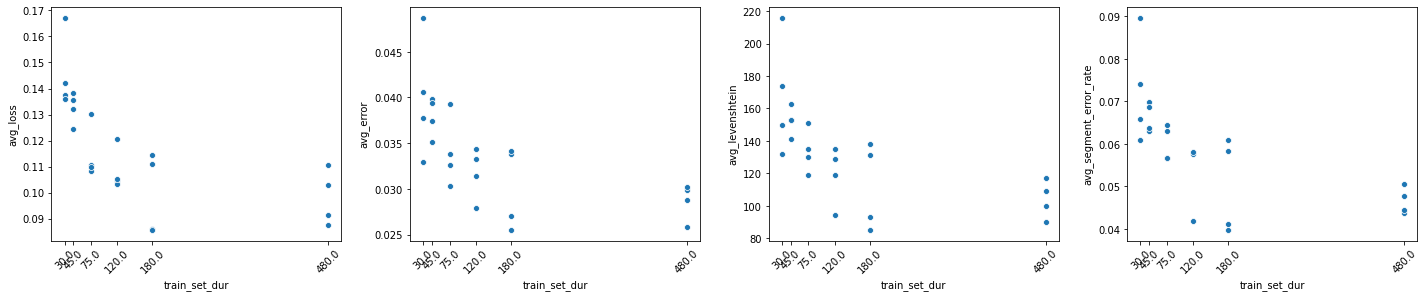

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax = ax.ravel()
sns.scatterplot(x='train_set_dur', y='avg_loss', data=learncurve_df, ax=ax[0])
sns.scatterplot(x='train_set_dur', y='avg_error', data=learncurve_df, ax=ax[1])
sns.scatterplot(x='train_set_dur', y='avg_levenshtein', data=learncurve_df, ax=ax[2])
sns.scatterplot(x='train_set_dur', y='avg_segment_error_rate', data=learncurve_df, ax=ax[3]);
fig.tight_layout()

for axes in ax:
    axes.set_xticks(learncurve_df['train_set_dur'].unique())
    axes.set_xticklabels(learncurve_df['train_set_dur'].unique(), rotation=45)